<a href="https://colab.research.google.com/github/SLTHRN/Heart_disease_ML/blob/main/Project_v_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
### IMPORT LIBRARIES

import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sklearn

import time

In [15]:
### IMPORTING CSV FILE FROM GOOGLE DRIVE

import csv
from google.colab import drive
drive.mount('/content/drive')

#FILE LOCATION IN GOOGLE DRIVE
directory = '/content/drive/MyDrive/APS360PROJECT/New data.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
### DEFINING CNN MODEL NETWORK

import torch
import torch.nn as nn
import torch.nn.functional as F

#DEFINING A 3 LAYER FULLY CONNECTED MODEL
class neuralNetwork(nn.Module):

  def __init__(self):
    super(neuralNetwork, self).__init__()
    self.layer1 = nn.Linear(13,50)
    self.layer2 = nn.Linear(50,70)
    self.layer3 = nn.Linear(70,5)

  def forward(self, x):
    #x = x.squeeze()
    activation1 = self.layer1(x)
    activation1 = F.softmax(activation1)
    activation2 = F.softmax(self.layer2(activation1))
    output = self.layer3(activation2)
    return output

In [17]:
### LOADING CSV FILE FROM DIRECTORY

def load_csv(directory):
  file = open(directory, "r")
  retrieved = csv.reader(file)

  data_size = -1
  dictionary = {}
  data = []

  for row in retrieved:
    data_size+= 1
    if data_size == 0:
      for i in range(len(row)):
        dictionary[i] = row[i]
    else:
      data.append(row)

  return data_size, data, dictionary

In [18]:
### DATA STRING TO FLOAT

def str_to_flt(data):
  fail_count = 0

  for i in range(len(data)):
    row = data[i]
    new_row = []
    for j in range(len(row)):
      if row[j].isnumeric():
        new_row.append(float(row[j]))
      else:
        test = row[j].split('.')
        if len(test) == 2 and (test[0].isnumeric() and test[1].isnumeric()):
          new_row.append(float(row[j]))
        else:
          fail_count += 1
          print('!!!!!! Not Numeric, count:' + str(fail_count))
          new_row.append(row[j])
    data[i] = new_row
  return data

In [19]:
### GET LABELS

def seperate_labels(data):
  labels = []

  for row in data:
    labels.append(int(row[-1]))
    del row[-1]

  #labels = get_one_hot(labels)

  return data, labels

In [20]:
### TURN LABELS INTO ONE-HOT ENCODINGS

def get_one_hot(labels):
  new_labels = []
  for label in labels:
    if label == 0.0:
      new_labels.append([1,0,0,0,0])
    elif label == 1.0:
      new_labels.append([0,1,0,0,0])
    elif label == 2.0:
      new_labels.append([0,0,1,0,0])
    elif label == 3.0:
      new_labels.append([0,0,0,1,0])
    elif label == 4.0:
      new_labels.append([0,0,0,0,1])
  return new_labels


In [21]:
### GENERATING SAMPLERS FOR DATALOADERS

def get_samplers(data_size):
  torch.manual_seed(0)
  index = torch.randperm(data_size)
  end_training = int(len(index)*0.6) # Defining index for last data sample in training data
  end_validation = end_training + int(len(index)*0.2) # Defining index for last data sample in validation set

  training_sampler, validation_sampler, testing_sampler = index[:end_training], index[end_training:end_validation], index[end_validation:]

  return training_sampler, validation_sampler, testing_sampler

In [22]:
### GENERATING DATA LOADERS

def get_loaders(data, sampler, batch_size = 64):
  dataset = torch.tensor(data)

  loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, sampler=sampler)
  
  return loader

In [23]:
### CALCULATE ACCURACY OF MODEL

def get_accuracy(model, d_loader, l_loader, show_data = False):
  correct = 0
  total = 0

  for (data, label) in zip(d_loader, l_loader):
    output = model(data)
    pred = output.max(1)[1]
    if show_data:
      print("The predictions are: {}".format(pred))
      print("The labels are: {}".format(label))
    for i in range(len(pred)):
      total += 1.0
      if label[i] == pred[i]:
        correct += 1.0
  return correct/total

In [24]:
### MODEL TRAINING

def training(t_loader, t_label_loader, v_loader, v_label_loader, epochs=10, learning_rate=0.001):
  n = 0
  iters, losses, training_accuracy, validation_accuracy = [], [], [], []

  model = neuralNetwork()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  print("Starting training")
  start_time = time.time()
  for epoch in range(epochs):
    for (data, label) in zip(t_loader, t_label_loader):
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      iters.append(n)
      losses.append(float(loss)/batch_size)
      training_accuracy.append(get_accuracy(model, t_loader, t_label_loader))
      validation_accuracy.append(get_accuracy(model, v_loader, v_label_loader))
      n += 1

  end_time=time.time()
  print("Done training, time elapsed: {:.2f} seconds".format(end_time-start_time))
  print("Number of iterations: {}".format(iters[-1]+1))
  print("Number of epochs: {}".format(epochs))
  plt.title("Training")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Accuracies")
  plt.plot(iters, validation_accuracy, label = "Validation")
  plt.plot(iters, training_accuracy, label = "Training")
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.show

  print("Final loss: {}".format(losses[-1]))
  print("Final training accuracy: {}".format(training_accuracy[-1]))
  print("Final validation accuracy: {}".format(validation_accuracy[-1]))
  return model

In [25]:
### GET BALANCE OF DATA

def data_balance(label_loader, training = False, validation = False, testing = False, get_total = False, get_ones = False, get_twos = False, get_threes = False, get_fours = False):
  num_zeros, num_ones, num_twos, num_threes, num_fours, total = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
  for batch in label_loader:
    for element in batch:
      total += 1.0
      if element == 0.0:
        num_zeros += 1.0
      elif element == 1.0:
        num_ones += 1.0
      elif element == 2.0:
        num_twos += 1.0
      elif element == 3.0:
        num_threes += 1.0
      elif element == 4.0:
        num_fours += 1.0
  if training:
    data = "training"
  elif validation:
    data = "validation"
  elif testing:
    data = testing
  else:
    data = "misc."
  print("Percentage of {} data with label 0: {}%".format(data, num_zeros/total))
  if get_ones:
    print("Percentage of {} data with label 1: {}%".format(data, num_ones/total))
  if get_twos:
    print("Percentage of {} data with label 2: {}%".format(data, num_twos/total))
  if get_threes:
    print("Percentage of {} data with label 3: {}%".format(data, num_threes/total))
  if get_fours:
    print("Percentage of {} data with label 4: {}%".format(data, num_fours/total))
  if get_total:
    print("Size of {} set: {}".format(data, int(total)))

Percentage of training data with label 0: 0.5224719101123596%
Size of training set: 178.0
Percentage of validation data with label 0: 0.5254237288135594%
Size of validation set: 59.0
Percentage of True data with label 0: 0.6%
Size of True set: 60.0
Starting training


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Done training, time elapsed: 1.99 seconds
Number of iterations: 180
Number of epochs: 10


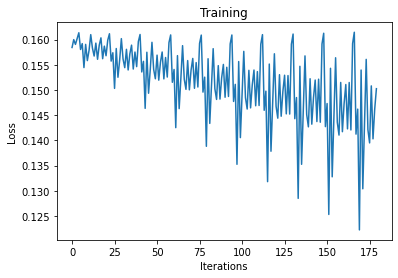

Final loss: 0.1502612590789795
Final training accuracy: 0.5224719101123596
Final validation accuracy: 0.5254237288135594
The predictions are: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
The labels are: tensor([0, 1, 1, 0, 0, 0, 0, 2, 0, 0])
The predictions are: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
The labels are: tensor([2, 0, 0, 0, 2, 0, 0, 3, 1, 0])
The predictions are: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
The labels are: tensor([2, 0, 2, 3, 1, 1, 0, 0, 0, 0])
The predictions are: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
The labels are: tensor([0, 1, 0, 0, 0, 0, 0, 2, 0, 0])
The predictions are: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
The labels are: tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 0])
The predictions are: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
The labels are: tensor([1, 1, 2, 0, 0, 0, 1, 0, 0, 1])
Testing accuracy: 0.6


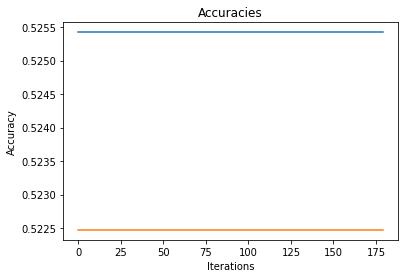

In [27]:
### RUNNING THE CODE

data_size, data, dictionary = load_csv(directory)
data = str_to_flt(data)
data, labels = seperate_labels(data)
training_sampler, validation_sampler, testing_sampler = get_samplers(data_size)

batch_size = 10
training_loader = get_loaders(data, training_sampler, batch_size)
training_label_loader = get_loaders(labels, training_sampler, batch_size)
validation_loader = get_loaders(data, validation_sampler, batch_size)
validation_label_loader = get_loaders(labels, validation_sampler, batch_size)
testing_loader = get_loaders(data, testing_sampler, batch_size)
testing_label_loader = get_loaders(labels, testing_sampler, batch_size)

data_balance(training_label_loader, training = True, get_total = True)
data_balance(validation_label_loader, validation = True, get_total = True)
data_balance(testing_label_loader, testing = True, get_total = True)

model = training(training_loader, training_label_loader, validation_loader, validation_label_loader)
print("Testing accuracy: {}".format(get_accuracy(model, testing_loader, testing_label_loader, show_data = True)))